In [1]:
import os, sys
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import torch
import pandas as pd 

# 0. Prepare Data

### specify the directories used for running the code:
* `data_dir`: where raw dataset is loaded; raw data is in csv format
* `processed_data_dir`: where processed dataset is loaded; processed data is in npy pickle format
    * processed data should be a ndarray of shape (participants_num x sessions_num(3) x days_per_session(10)*trail_per_day(4) x #examples_window*#mov(26*22=572) x processed_channel_num(252))
    * for instance: processed examples have shape **(5, 3, 40, 572, 252)** and labels have shape **(5, 3, 40, 572)**
* `path_<model_name>`: where model weights are saved
    * weights should be saved in folder `/Weights/<model_name>`. Each folder has subfolders containing weights for each participant.
    * weights for TSD model contain 3 set of training model. weights for DANN and SCADANN contain 2 set of trianing model (these two models are trianed based on TSD, so they do not have a best_state_0.pt model. 
* `save_<model_name>`: where model results are saved
    * each result for testing a model on a group of datset is saved in folder `results`. Each result has corresponding 
        * `<model_name>.txt` includes predictions, ground truths, array of accuracies for each participant and each session, and overall accuracy
        * `predictions_<model_name>.npy` includes array of accuracies, ground truths, predictions, and model outputs (probability array for each prediction)
        * remember to make blank files in these names before saving

* use `read_data_training` to process raw dataset

* `switch`=2 runs inter-day trainings
* use `sessions_to_include` to indicate which wearing location should be included. Due to the structure of training model, only one wearing location can be included. The default locaiton to include is Neutral. 
        

In [2]:
os.chdir("/home/laiy/gitrepos/msr_final/LongTermEMG_myo")
from PrepareAndLoadData.process_data import read_data_training

In [3]:
data_dir = "/home/laiy/gitrepos/msr_final/Wearable_Sensor_Long-term_sEMG_Dataset/data"
processed_data_dir = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/Processed_datasets_all_across_day_loc_2"
code_dir = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo"
save_dir = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/Results"

path_TSD ="/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/Weights_across_day_loc_2/TSD"
save_TSD = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/results"

path_DANN ="/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/Weights_across_day_loc_2/DANN"
save_DANN = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/results"

path_SCADANN ="/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/Weights_across_day_loc_2/SCADANN"
save_SCADANN = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/results"

In [4]:
# read_data_training(path=data_dir, store_path = processed_data_dir, num_participant=5, 
#                    sessions_to_include =[1], switch=2)

In [5]:
# check stored pickle 
with open(processed_data_dir + "/training_session.pickle", 'rb') as f:
    dataset_training = pickle.load(file=f)

examples_datasets_train = dataset_training['examples_training']
print('traning examples ', np.shape(examples_datasets_train))
labels_datasets_train = dataset_training['labels_training']
print('traning labels ', np.shape(labels_datasets_train))

traning examples  (5, 10, 4, 572, 252)
traning labels  (5, 10, 4, 572)


### Specify params used for training and testing

During training and testing, processed datasets are first put into pytorch dataloders, then feed to the model trainer; following are params for TSD model and dataloaders

* `num_kernels`: list of integers defining number of neurons used in each layer of linear block (linear block has `dropout`=0.5)
* `number_of_cycles_total`: number of trails performed for each session (assuming that all session have the same trail size)
    * 40 for myo
* `number_of_classes`: total number of gestures performed in dataset
    * 22 for myo
* `batch_size`: number of examples stored in each batch
* `feature_vector_input_length`: length of input array or each processed signal 
    * 252 for myo
* `learning_rate`= 0.002515
    

In [6]:
num_kernels=[200, 200, 200]                        # model layer size 
number_of_cycles_total=np.shape(examples_datasets_train[0][0])[0]               # #session
print("number_of_cycles_total ", number_of_cycles_total)
number_of_classes=22
batch_size=128          
feature_vector_input_length=252                     # size of one example 
learning_rate=0.002515

number_of_cycles_total  4


# 1. TSD_DNN
* `train_fine_tuning`: used to train data using TSD network only   
    * running this function will save three sets of TSD model weights (each is fine tuned based on the previous training)  
    
* `test_TSD_DNN_on_training_sessions`: test model result


### check if dataloaders are loaded correctly:
* each participant has shape (session_num x 40 x 572 x 252)
* each session has shape (40 x 572 x 252)
* put these data into on group ends up with shape (40*572=22880, 252)
    * shuffle on group of data and put into dataloaders
    * each participant should have 3 sets of dataloaders, each correspond to one session

In [7]:
from TrainingsAndEvaluations.ForTrainingSessions.train_tsd_dnn_standard import \
            test_TSD_DNN_on_training_sessions, train_fine_tuning

In [8]:
# train_fine_tuning(examples_datasets_train, labels_datasets_train,
#                   num_kernels=num_kernels, path_weight_to_save_to=path_TSD,
#                   number_of_classes=number_of_classes, number_of_cycles_total=number_of_cycles_total,
#                   batch_size=batch_size,
#                   feature_vector_input_length=feature_vector_input_length,
#                   learning_rate=learning_rate)

In [9]:
algo_name = "standard_TSD"
test_TSD_DNN_on_training_sessions(examples_datasets_train, labels_datasets_train,
                                  num_neurons=num_kernels, use_only_first_training=True,
                                  path_weights=path_TSD,
                                  feature_vector_input_length=feature_vector_input_length,
                                  save_path = save_TSD, algo_name=algo_name,
                                  number_of_cycles_total=number_of_cycles_total,
                                  number_of_classes=number_of_classes, cycle_for_test=3)

GET one participant_examples  (10, 4, 572, 252)
   GET one training_index_examples  (4, 572, 252)  at  0
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  1
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  2
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  3
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (20

       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  3
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  4
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  5
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  6
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (57

In [10]:
results_filename = save_TSD + '/predictions_' + algo_name + "_no_retraining.npy"
results = np.load(results_filename, allow_pickle=True)
TSD_acc = results[0]
TSD_acc_overall = np.mean(TSD_acc)
TSD_df = pd.DataFrame(TSD_acc.transpose(), 
                       index = [f'Day_{i}' for i in range(TSD_acc.shape[1])],
                        columns = [f'Participant_{j}' for j in range(TSD_acc.shape[0])])
TSD_df

,Participant_0,Participant_1,Participant_2,Participant_3,Participant_4
Day_0,0.986014,0.993007,0.993007,0.993007,0.98951
Day_1,0.657343,0.879371,0.725524,0.666084,0.833916
Day_2,0.722028,0.868881,0.777972,0.625874,0.725524
Day_3,0.388112,0.907343,0.486014,0.550699,0.636364
Day_4,0.472028,0.81993,0.550699,0.611888,0.657343
Day_5,0.590909,0.758741,0.52972,0.533217,0.498252
Day_6,0.631119,0.676573,0.545455,0.555944,0.52972
Day_7,0.643357,0.867133,0.561189,0.493007,0.358392
Day_8,0.722028,0.863636,0.596154,0.683566,0.354895
Day_9,0.671329,0.713287,0.594406,0.526224,0.395105


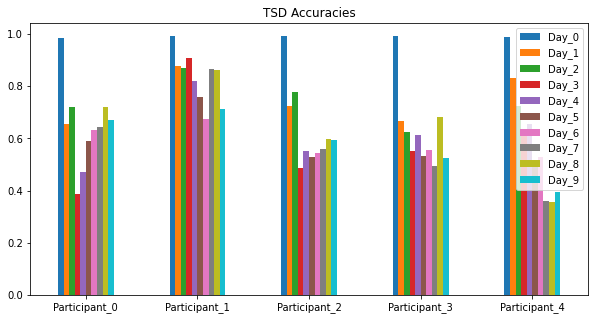

In [11]:
TSD_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("TSD Accuracies")
plt.show()

In [12]:
from TrainingsAndEvaluations.ForTrainingSessions.utils import get_gesture_accuracies

In [13]:
ground_truths = results[1]
predictions = results[2]
print("ground_truths  = ", np.shape(ground_truths))
print("predictions = ", np.shape(predictions))
m_name = "Loc2_Sub"
n_name = "Day"
df = get_gesture_accuracies(ground_truths, predictions, number_of_classes=number_of_classes, 
                            m_name=m_name, n_name=n_name, path=save_TSD, algo_name=algo_name)
df = pd.read_csv(save_TSD+'/'+algo_name+'.csv')
df

ground_truths  =  (5, 10)
predictions =  (5, 10)
accuracies_gestures =  (22, 50)


,Unnamed: 0,Loc2_Sub0_Day0,Loc2_Sub0_Day1,Loc2_Sub0_Day2,Loc2_Sub0_Day3,Loc2_Sub0_Day4,Loc2_Sub0_Day5,Loc2_Sub0_Day6,Loc2_Sub0_Day7,Loc2_Sub0_Day8,...,Loc2_Sub4_Day0,Loc2_Sub4_Day1,Loc2_Sub4_Day2,Loc2_Sub4_Day3,Loc2_Sub4_Day4,Loc2_Sub4_Day5,Loc2_Sub4_Day6,Loc2_Sub4_Day7,Loc2_Sub4_Day8,Loc2_Sub4_Day9
0,M0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.230769,1.000000
1,M1,0.961538,0.000000,0.000000,0.500000,0.000000,0.692308,0.000000,0.807692,0.461538,...,1.000000,0.923077,0.961538,0.500000,0.692308,0.769231,0.384615,0.038462,0.115385,0.346154
2,M2,0.884615,0.000000,0.038462,0.153846,0.423077,0.076923,0.269231,0.000000,0.000000,...,1.000000,0.846154,0.538462,0.615385,0.769231,0.538462,0.576923,0.269231,0.538462,0.538462
3,M3,1.000000,0.653846,0.961538,0.500000,0.000000,0.692308,0.730769,0.000000,0.884615,...,1.000000,1.000000,0.576923,0.076923,0.500000,0.076923,0.230769,0.000000,0.000000,0.000000
4,M4,0.923077,0.307692,0.384615,0.653846,0.307692,0.384615,0.807692,0.500000,0.769231,...,1.000000,0.807692,0.730769,0.000000,0.615385,0.000000,0.000000,0.000000,0.000000,0.000000
5,M5,1.000000,0.346154,0.576923,0.076923,0.038462,0.500000,0.807692,0.461538,0.384615,...,1.000000,0.769231,0.846154,0.730769,1.000000,0.923077,0.692308,0.000000,0.423077,0.461538
6,M6,1.000000,0.346154,0.769231,0.346154,0.653846,0.153846,0.230769,0.153846,1.000000,...,1.000000,1.000000,0.961538,0.423077,1.000000,0.807692,0.307692,0.538462,0.153846,1.000000
7,M7,1.000000,1.000000,1.000000,1.000000,0.576923,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.884615,0.269231,0.576923,0.192308,0.192308,0.346154,0.000000,0.153846,0.346154
8,M8,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.884615,0.807692,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
9,M9,1.000000,1.000000,1.000000,0.423077,0.884615,0.692308,1.000000,1.000000,1.000000,...,1.000000,0.846154,0.961538,0.769231,0.730769,0.615385,0.807692,0.384615,0.576923,0.461538


# 2. DANN
* `train_DANN`: train DANN model using the first set of training weights from TSD model
    * two set of training weights will be saved
* `test_DANN_on_training_sessions`: test DANN model

In [14]:
from TrainingsAndEvaluations.ForTrainingSessions.train_tsd_dnn_DA import train_DANN, test_DANN_on_training_sessions

In [15]:
# train_DANN(examples_datasets_train, labels_datasets_train, 
#           num_kernels=num_kernels,
#           path_weights_fine_tuning=path_TSD,
#           number_of_classes=number_of_classes,
#           number_of_cycles_total = number_of_cycles_total,
#           batch_size=batch_size,
#           feature_vector_input_length=feature_vector_input_length,
#           path_weights_to_save_to=path_DANN, learning_rate=learning_rate)

In [16]:
algo_name = "DANN"
test_DANN_on_training_sessions(examples_datasets_train, labels_datasets_train,
                              feature_vector_input_length=feature_vector_input_length,
                              num_neurons=num_kernels, path_weights_DA=path_DANN,
                              algo_name=algo_name, save_path = save_DANN, 
                              number_of_cycles_total=number_of_cycles_total,
                              path_weights_normal=path_TSD, number_of_classes=number_of_classes,
                              cycle_for_test=3)

GET one participant_examples  (10, 4, 572, 252)
   GET one training_index_examples  (4, 572, 252)  at  0
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  1
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  2
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  3
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (20

   GET one training_index_examples  (4, 572, 252)  at  3
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  4
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  5
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  6
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (22

Participant ID:  4  Session ID:  5  Accuracy:  0.5734265734265734
Participant ID:  4  Session ID:  6  Accuracy:  0.6765734265734266
Participant ID:  4  Session ID:  7  Accuracy:  0.42482517482517484
Participant ID:  4  Session ID:  8  Accuracy:  0.45454545454545453
Participant ID:  4  Session ID:  9  Accuracy:  0.3811188811188811
ACCURACY PARTICIPANT:  [0.9895104895104895, 0.8356643356643356, 0.7447552447552448, 0.6958041958041958, 0.7237762237762237, 0.5734265734265734, 0.6765734265734266, 0.42482517482517484, 0.45454545454545453, 0.3811188811188811]
[[0.98601399 0.7465035  0.79370629 0.47552448 0.52272727 0.69755245
  0.72902098 0.71328671 0.7972028  0.68881119]
 [0.99300699 0.91783217 0.91258741 0.89335664 0.86188811 0.82867133
  0.73076923 0.85664336 0.89335664 0.8041958 ]
 [0.99300699 0.68181818 0.78671329 0.50699301 0.5541958  0.58741259
  0.57167832 0.5979021  0.62412587 0.59615385]
 [0.99300699 0.71853147 0.63636364 0.60314685 0.63811189 0.5979021
  0.6486014  0.5506993  0.7097

In [17]:
results_filename = save_DANN + '/predictions_' + algo_name + ".npy"
results = np.load(results_filename, allow_pickle=True)
DANN_acc = results[0]
DANN_acc_overall = np.mean(DANN_acc)
DANN_df = pd.DataFrame(DANN_acc.transpose(), 
                       index = [f'Day_{i}' for i in range(DANN_acc.shape[1])],
                        columns = [f'Participant_{j}' for j in range(DANN_acc.shape[0])])
DANN_df

,Participant_0,Participant_1,Participant_2,Participant_3,Participant_4
Day_0,0.986014,0.993007,0.993007,0.993007,0.98951
Day_1,0.746503,0.917832,0.681818,0.718531,0.835664
Day_2,0.793706,0.912587,0.786713,0.636364,0.744755
Day_3,0.475524,0.893357,0.506993,0.603147,0.695804
Day_4,0.522727,0.861888,0.554196,0.638112,0.723776
Day_5,0.697552,0.828671,0.587413,0.597902,0.573427
Day_6,0.729021,0.730769,0.571678,0.648601,0.676573
Day_7,0.713287,0.856643,0.597902,0.550699,0.424825
Day_8,0.797203,0.893357,0.624126,0.70979,0.454545
Day_9,0.688811,0.804196,0.596154,0.573427,0.381119


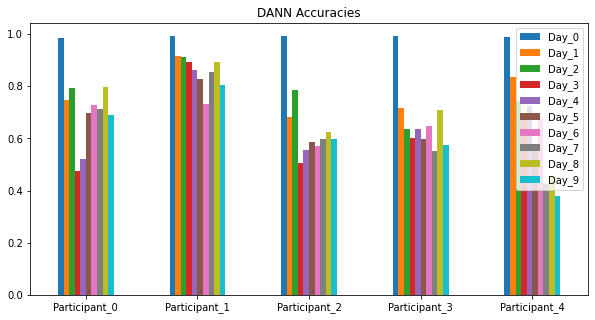

In [18]:
DANN_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("DANN Accuracies")
plt.show()

In [19]:
ground_truths = results[1]
predictions = results[2]
print("ground_truths  = ", np.shape(ground_truths))
print("predictions = ", np.shape(predictions))
m_name = "Loc2_Sub"
n_name = "Day"
df = get_gesture_accuracies(ground_truths, predictions, number_of_classes=number_of_classes, 
                            m_name=m_name, n_name=n_name, path=save_TSD, algo_name=algo_name)
df = pd.read_csv(save_TSD+'/'+algo_name+'.csv')
df

ground_truths  =  (5, 10)
predictions =  (5, 10)
accuracies_gestures =  (22, 50)


,Unnamed: 0,Loc2_Sub0_Day0,Loc2_Sub0_Day1,Loc2_Sub0_Day2,Loc2_Sub0_Day3,Loc2_Sub0_Day4,Loc2_Sub0_Day5,Loc2_Sub0_Day6,Loc2_Sub0_Day7,Loc2_Sub0_Day8,...,Loc2_Sub4_Day0,Loc2_Sub4_Day1,Loc2_Sub4_Day2,Loc2_Sub4_Day3,Loc2_Sub4_Day4,Loc2_Sub4_Day5,Loc2_Sub4_Day6,Loc2_Sub4_Day7,Loc2_Sub4_Day8,Loc2_Sub4_Day9
0,M0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.923077,0.923077,1.000000,...,1.000000,1.000000,0.038462,1.000000,1.000000,1.000000,1.000000,1.000000,0.307692,1.000000
1,M1,0.961538,0.000000,0.269231,0.692308,0.153846,0.923077,0.653846,0.961538,1.000000,...,1.000000,1.000000,0.961538,0.730769,0.846154,1.000000,0.846154,0.615385,0.576923,0.653846
2,M2,0.884615,0.000000,0.153846,0.000000,0.307692,0.000000,0.884615,0.000000,0.000000,...,1.000000,0.884615,0.576923,0.692308,0.769231,0.538462,0.653846,0.423077,0.576923,0.615385
3,M3,1.000000,1.000000,1.000000,0.192308,0.000000,0.961538,0.615385,0.153846,0.923077,...,1.000000,1.000000,0.576923,0.461538,0.769231,0.615385,0.653846,0.192308,0.000000,0.000000
4,M4,0.923077,0.192308,0.538462,0.615385,0.153846,0.269231,0.769231,0.307692,0.692308,...,1.000000,0.961538,0.923077,0.192308,0.923077,0.000000,0.000000,0.000000,0.000000,0.000000
5,M5,1.000000,0.384615,0.807692,0.192308,0.192308,0.923077,1.000000,0.884615,0.346154,...,1.000000,0.961538,0.884615,0.884615,1.000000,0.961538,1.000000,0.115385,1.000000,0.576923
6,M6,1.000000,0.846154,1.000000,0.653846,1.000000,0.923077,0.115385,0.192308,0.923077,...,1.000000,1.000000,1.000000,0.384615,1.000000,1.000000,0.346154,0.846154,0.230769,1.000000
7,M7,1.000000,1.000000,1.000000,1.000000,0.653846,1.000000,1.000000,1.000000,0.961538,...,1.000000,0.884615,0.307692,0.884615,0.346154,0.346154,0.846154,0.153846,0.384615,0.384615
8,M8,1.000000,1.000000,0.961538,1.000000,0.807692,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.769231,0.884615,1.000000,1.000000,1.000000,0.923077,1.000000,0.923077,0.692308
9,M9,1.000000,1.000000,1.000000,0.461538,0.961538,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.807692,0.961538,0.692308,0.692308,0.384615,0.461538,0.115385,0.346154,0.192308


# 3. SCADANN
* `run_SCADANN_training_sessions`: train SCADANN model. The first session uses TSD model_0 wegits; others use DANN weights
    * specify `percentage_same_gesture_stable` based on the performance of most pseudo labels 
        * print accuracies out and check what percentage will optimize `ACCURACY MODEL` and `ACCURACY PSEUDO` without cutting out too much data 
    * two set of training weights will be saved
* `test_network_SLADANN`: test DANN model

In [20]:
from TrainingsAndEvaluations.ForTrainingSessions.train_tsd_dnn_SCADANN import run_SCADANN_training_sessions, test_network_SLADANN

In [21]:
# percentage_same_gesture_stable = 0.75 
# run_SCADANN_training_sessions(examples_datasets=examples_datasets_train, labels_datasets=labels_datasets_train,
#                               num_kernels=num_kernels, feature_vector_input_length=feature_vector_input_length,
#                               path_weights_to_save_to=path_SCADANN,
#                               path_weights_Adversarial_training=path_DANN,
#                               path_weights_Normal_training=path_TSD,
#                               number_of_cycles_total = number_of_cycles_total, 
#                               number_of_classes=number_of_classes,
#                               learning_rate=learning_rate)

In [22]:
algo_name = "SCADANN"
test_network_SLADANN(examples_datasets_train=examples_datasets_train, labels_datasets_train=labels_datasets_train,
                     num_neurons=num_kernels, feature_vector_input_length=feature_vector_input_length,
                     path_weights_SCADANN =path_SCADANN, path_weights_normal=path_TSD,
                     algo_name=algo_name, cycle_test=3, number_of_cycles_total=number_of_cycles_total,
                     number_of_classes=number_of_classes, save_path = save_SCADANN)

GET one participant_examples  (10, 4, 572, 252)
   GET one training_index_examples  (4, 572, 252)  at  0
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  1
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  2
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  3
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (20

   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  2
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  3
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  4
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)

In [23]:
results_filename = save_SCADANN + '/predictions_' + algo_name + ".npy"
results = np.load(results_filename, allow_pickle=True)
SCADANN_acc = results[0]
SCADANN_acc_overall = np.mean(SCADANN_acc)
SCADANN_df = pd.DataFrame(SCADANN_acc.transpose(), 
                       index = [f'Day_{i}' for i in range(SCADANN_acc.shape[1])],
                        columns = [f'Participant_{j}' for j in range(SCADANN_acc.shape[0])])
SCADANN_df

,Participant_0,Participant_1,Participant_2,Participant_3,Participant_4
Day_0,0.986014,0.993007,0.993007,0.993007,0.98951
Day_1,0.777972,0.958042,0.743007,0.763986,0.874126
Day_2,0.816434,0.944056,0.805944,0.655594,0.77972
Day_3,0.533217,0.928322,0.552448,0.590909,0.767483
Day_4,0.552448,0.909091,0.58042,0.704545,0.784965
Day_5,0.729021,0.858392,0.625874,0.61014,0.645105
Day_6,0.802448,0.798951,0.613636,0.673077,0.729021
Day_7,0.800699,0.945804,0.641608,0.58042,0.520979
Day_8,0.888112,0.91958,0.646853,0.769231,0.554196
Day_9,0.718531,0.914336,0.634615,0.618881,0.496503


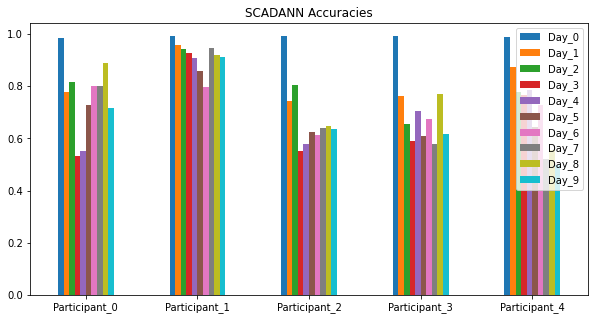

In [24]:
SCADANN_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("SCADANN Accuracies")
plt.show()

In [25]:
ground_truths = results[1]
predictions = results[2]
print("ground_truths  = ", np.shape(ground_truths))
print("predictions = ", np.shape(predictions))
m_name = "Loc2_Sub"
n_name = "Day"
df = get_gesture_accuracies(ground_truths, predictions, number_of_classes=number_of_classes, 
                            m_name=m_name, n_name=n_name, path=save_TSD, algo_name=algo_name)
df = pd.read_csv(save_TSD+'/'+algo_name+'.csv')
df

ground_truths  =  (5, 10)
predictions =  (5, 10)
accuracies_gestures =  (22, 50)


,Unnamed: 0,Loc2_Sub0_Day0,Loc2_Sub0_Day1,Loc2_Sub0_Day2,Loc2_Sub0_Day3,Loc2_Sub0_Day4,Loc2_Sub0_Day5,Loc2_Sub0_Day6,Loc2_Sub0_Day7,Loc2_Sub0_Day8,...,Loc2_Sub4_Day0,Loc2_Sub4_Day1,Loc2_Sub4_Day2,Loc2_Sub4_Day3,Loc2_Sub4_Day4,Loc2_Sub4_Day5,Loc2_Sub4_Day6,Loc2_Sub4_Day7,Loc2_Sub4_Day8,Loc2_Sub4_Day9
0,M0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.269231,1.000000
1,M1,0.961538,0.000000,0.192308,0.692308,0.115385,1.000000,0.653846,0.961538,1.000000,...,1.000000,1.000000,1.000000,0.807692,0.884615,1.000000,0.846154,0.692308,0.692308,0.769231
2,M2,0.884615,0.000000,0.000000,0.000000,0.423077,0.000000,0.576923,0.000000,0.000000,...,1.000000,0.923077,0.576923,0.615385,0.846154,0.538462,0.730769,0.423077,0.576923,0.576923
3,M3,1.000000,1.000000,1.000000,0.192308,0.000000,0.961538,0.692308,0.384615,0.961538,...,1.000000,1.000000,0.730769,0.807692,0.807692,0.769231,0.653846,0.423077,0.307692,0.230769
4,M4,0.923077,0.153846,0.461538,0.730769,0.115385,0.153846,0.769231,0.346154,0.692308,...,1.000000,1.000000,1.000000,0.192308,1.000000,0.000000,0.000000,0.000000,0.038462,0.000000
5,M5,1.000000,0.384615,0.923077,0.423077,0.115385,0.846154,1.000000,1.000000,0.846154,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.192308,1.000000,0.576923
6,M6,1.000000,1.000000,1.000000,0.884615,1.000000,1.000000,0.500000,0.538462,0.961538,...,1.000000,1.000000,1.000000,0.538462,1.000000,1.000000,0.576923,1.000000,0.730769,1.000000
7,M7,1.000000,1.000000,1.000000,1.000000,0.730769,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.923077,0.115385,1.000000,0.769231,0.500000,1.000000,0.576923,0.615385,0.653846
8,M8,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.923077,0.923077,1.000000,1.000000,1.000000,0.923077,1.000000,0.961538,0.807692
9,M9,1.000000,1.000000,1.000000,0.653846,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.807692,1.000000,0.692308,0.769231,0.653846,0.692308,0.269231,0.576923,0.192308


# Conclusion
In general, overall accuracies of SCADANN is better than DANN, and DANN is better than TSD.   

Occasionally accuracies of SCADANN ends up a little smaller than DANN, reasons may be lack of datasets put into training model (fixed) and non-optimal percentage_same_gesture_sable (fixed). Code should be reproducable if processed dataset stick to the shape defined above.

* What to check if sth goes wrong:
    * percentage_same_gesture_sable
    * number of cycles or sessions
    * shape of dataloaders (combination of train, test, valid should include all dataset)
    * shape of procssed datasets
    * directory paths of weights and results
    * if weights are stored or loaded correclty

In [26]:
print("TSD")
display(TSD_df)
print("DANN")
display(DANN_df)
print("SCADANN")
display(SCADANN_df)

TSD


,Participant_0,Participant_1,Participant_2,Participant_3,Participant_4
Day_0,0.986014,0.993007,0.993007,0.993007,0.98951
Day_1,0.657343,0.879371,0.725524,0.666084,0.833916
Day_2,0.722028,0.868881,0.777972,0.625874,0.725524
Day_3,0.388112,0.907343,0.486014,0.550699,0.636364
Day_4,0.472028,0.81993,0.550699,0.611888,0.657343
Day_5,0.590909,0.758741,0.52972,0.533217,0.498252
Day_6,0.631119,0.676573,0.545455,0.555944,0.52972
Day_7,0.643357,0.867133,0.561189,0.493007,0.358392
Day_8,0.722028,0.863636,0.596154,0.683566,0.354895
Day_9,0.671329,0.713287,0.594406,0.526224,0.395105


DANN


,Participant_0,Participant_1,Participant_2,Participant_3,Participant_4
Day_0,0.986014,0.993007,0.993007,0.993007,0.98951
Day_1,0.746503,0.917832,0.681818,0.718531,0.835664
Day_2,0.793706,0.912587,0.786713,0.636364,0.744755
Day_3,0.475524,0.893357,0.506993,0.603147,0.695804
Day_4,0.522727,0.861888,0.554196,0.638112,0.723776
Day_5,0.697552,0.828671,0.587413,0.597902,0.573427
Day_6,0.729021,0.730769,0.571678,0.648601,0.676573
Day_7,0.713287,0.856643,0.597902,0.550699,0.424825
Day_8,0.797203,0.893357,0.624126,0.70979,0.454545
Day_9,0.688811,0.804196,0.596154,0.573427,0.381119


SCADANN


,Participant_0,Participant_1,Participant_2,Participant_3,Participant_4
Day_0,0.986014,0.993007,0.993007,0.993007,0.98951
Day_1,0.777972,0.958042,0.743007,0.763986,0.874126
Day_2,0.816434,0.944056,0.805944,0.655594,0.77972
Day_3,0.533217,0.928322,0.552448,0.590909,0.767483
Day_4,0.552448,0.909091,0.58042,0.704545,0.784965
Day_5,0.729021,0.858392,0.625874,0.61014,0.645105
Day_6,0.802448,0.798951,0.613636,0.673077,0.729021
Day_7,0.800699,0.945804,0.641608,0.58042,0.520979
Day_8,0.888112,0.91958,0.646853,0.769231,0.554196
Day_9,0.718531,0.914336,0.634615,0.618881,0.496503


In [27]:
diff_df = SCADANN_df-TSD_df
diff_df = diff_df.drop('Day_0')
display(diff_df)
diff_df.to_csv(save_TSD+'/diff_results/across_day_loc2_diff.csv')

,Participant_0,Participant_1,Participant_2,Participant_3,Participant_4
Day_1,0.120629,0.078671,0.017483,0.097902,0.04021
Day_2,0.094406,0.075175,0.027972,0.02972,0.054196
Day_3,0.145105,0.020979,0.066434,0.04021,0.131119
Day_4,0.08042,0.089161,0.02972,0.092657,0.127622
Day_5,0.138112,0.09965,0.096154,0.076923,0.146853
Day_6,0.171329,0.122378,0.068182,0.117133,0.199301
Day_7,0.157343,0.078671,0.08042,0.087413,0.162587
Day_8,0.166084,0.055944,0.050699,0.085664,0.199301
Day_9,0.047203,0.201049,0.04021,0.092657,0.101399


In [28]:
overall_acc_df = pd.DataFrame([TSD_acc_overall, DANN_acc_overall, SCADANN_acc_overall],
                             index = ["TSD", "DANN", "SCADANN"],
                             columns = ["Overall_Acc"])
overall_acc_df

,Overall_Acc
TSD,0.668217
DANN,0.710245
SCADANN,0.754266


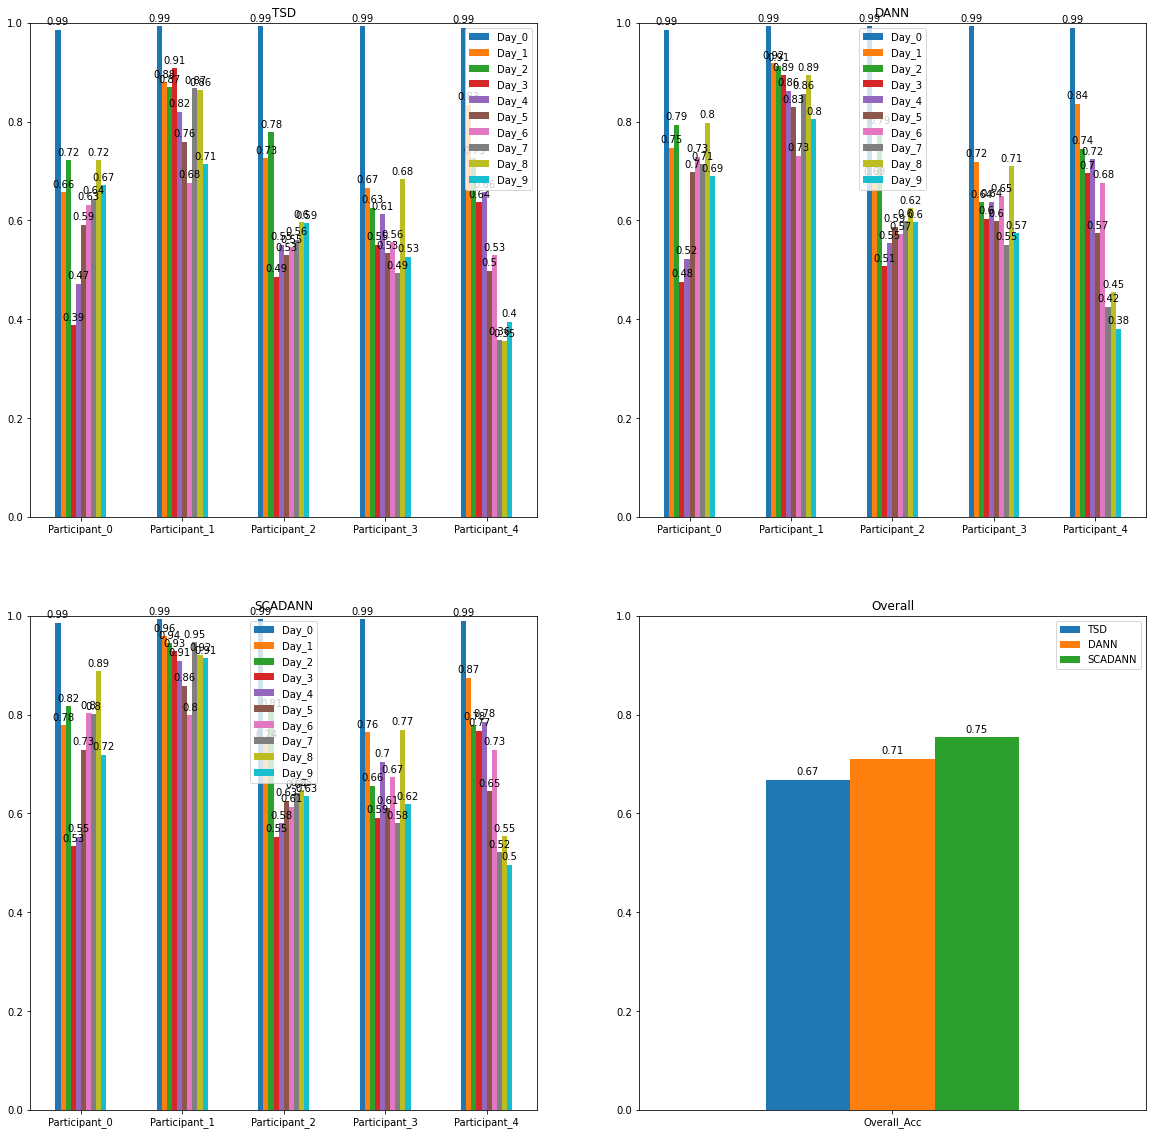

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
acc_list = [TSD_df, DANN_df, SCADANN_df, overall_acc_df]
title_list = ["TSD", "DANN", "SCADANN", "Overall"]
for idx, ax in enumerate(axes.reshape(-1)): 
    acc_list[idx].transpose().plot.bar(ax = ax, rot=0)
    ax.set_title(title_list[idx])
    ax.set_ylim([0, 1.0])
    for p in ax.patches:
        ax.annotate(str(np.round(p.get_height(),2)), (p.get_x()+p.get_width()/2., p.get_height()),
                    ha='center', va='center', xytext=(0, 8),textcoords='offset points')
fig.savefig("/home/laiy/gitrepos/msr_final/code/test_code/img/myo_results.jpg")